# Latent News Probability Model

Directly below contains the pip installs that are required for this project. If you run this code and still don't have the required packages, you may need to add a `!pip install [library_name]` into this code block. This does not need to be run every time the model is used.

IMPORTANT: If you are running this for the first time you may need to download these packages before continuing:

In [6]:
# #dataframe and sentiment analysis
# !pip install pandas
# !pip install spacy
# !pip install spacytextblob
# !python -m spacy download en_core_web_sm

# #webscraping
# !pip install newspaper3k

# #topic modeling 
# !pip install gensim

# #data vis
# !pip install plotly
# !pip install sklearn
# !pip install matplotlib
# !pip install wordcloud

Spacy: Used for NLP and has the machine learning module
    
SpacyTextBlob: Used for the sentiment analysis
    
Pandas: Stores the data as a dataframe table
    
NewsPaper: Used for web scraping

Gensim: Used for topic modeling
    
Requests: Makes the connection to the URL

Plotly: Used for data visualization

Matplotlib: Used for clustering and data visualization

Sklearn: Used for clustering and data visualization

## Start Here: Library Imports

In [26]:
#newspaper3k web scraping
from newspaper import Article

from random import shuffle
import re
import requests

from collections import Counter

#pandas dataframe
import pandas as pd

import numpy as np
import json
import requests
import glob

#gensim
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary  # Import the Dictionary class from Gensim

#spacy
import spacy
from nltk.corpus import stopwords
from spacytextblob.spacytextblob import SpacyTextBlob

#vis
import pyLDAvis
import pyLDAvis.gensim
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from sklearn.decomposition import PCA
import seaborn as sns



#K-Means Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

#Principled Component Analysis
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

IMPORTANT: Run all helper files. The function logic is stored here, and sorted by the part of the pipeline they support.

In [27]:
%run SentimentAnalysis.ipynb
%run WebScraper.ipynb
%run PipelineHelpers.ipynb
%run TopicModeling.ipynb
%run DataVisualization.ipynb

# General Pipeline Settings, and Pre-Analysis Setup

Below are the customizable settings for all of the analysis and processing parts of the pipeline.

Rerun this any time you make changes to these settings, as they will affect the outcome of certain pipeline steps.

IMPORTANT: The csvFile object should be set to a properly setup csv file of article URLs that you copy-paste into the same directory as the pipeline files (we use the relative path to access the file). The csvFile format is explained in the user manual, but simply it needs one column with the first entry being "Address" and the other entries all being article URLs.

In [28]:
###
### BELOW IS OUR CUSTOMIZABLE SETTINGS
###

# THIS IS THE CSV FILE THAT WE READ IN
# This csv file should contain a single column of article urls, with the first entry being "Address"
csv_file = "urls_gabriel_generated.csv"


#WEBSCRAPING SETTINGS
# THIS IS THE MINIMUM WORDS THAT WE ALLOW FOR AN ARTICLE
# (to prevent certain blocked articles or bad data)
word_count_filter = 150

#this is the minimum amount of repeated phrases in a text that we will throw an error for
repeated_phrase_filter = 25

#this is the list of all social media URLs that we BLOCK (anything in this list WILL NOT be scraped)
social_starts_with = ["https://www.youtube.com", "https://youtu.be", "https://www.facebook.com",
                          "https://twitter.com", "https://gettr.com/"]

#When webscraping, will only grab the first url_max URLs (set to -1 to turn off)
url_max = 500

# TOPIC MODELING SETTINGS
# this will set how our topic modeling is generated: limit to the # of topics,
# # of topics we start at, how many we increment by every step
topic_model_dict = {"topic_limit": 15, "topic_start": 6, "topic_step": 1}


###
### END OF CUSTOMIZABLE SETTINGS
###


# MAIN PIPELINE START

## Sentiment Analysis Pipeline

Below is the start of our pipeline.

Here we create our nlp object and add the pipe to it for sentiment analysis. We then read in our .csv file and convert it to a dataframe to pass in to our sentiment analysis function, and gathers the list of all URLs.

Our main_pipeline_sentiment_analysis() function takes in the list of urls, web scrapes their text, and performs sentiment analysis on them, creating a dataframe of all properly scraped articles and their associated sentiment analysis data.

df is the main dataframe object we store our data in.

In [29]:
# Loading the nlp pipeline and adding spacytextblob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob') #This is used in our sentiment analysis

# Using panda to load in our .csv file
# File we are checking
df = pd.read_csv(csv_file)
# Column name we are checking (You can switch this column name to match the csv file)
urls = df["Address"].tolist()

# Trim to only include the first url_max URLs
if url_max > 0:
    urls = urls[0:url_max]

# Here is where we start the sentiment analysis over all articles
df = main_pipeline_sentiment_analysis(urls)


0  Articles Completed
Webscraping failed: Word Count or Repeated Phrase
https://www.bbc.com/news/world-us-canada-55805698
Word count:  39
Repeated phrases:  1


10  Articles Completed
Webscraping failed: Word Count or Repeated Phrase
https://apnews.com/hub/hunter-biden
Word count:  42
Repeated phrases:  1


Webscraping failed: Word Count or Repeated Phrase
https://www.bbc.com/news/world-us-canada-55805698
Word count:  39
Repeated phrases:  1


20  Articles Completed
Webscraping failed: Word Count or Repeated Phrase
https://www.wdel.com/news/hunter-biden-prosecutor-wasnt-blocked-from-bringing-california-charges-us-attorney-tells-congress/article_f92d6768-7369-11ee-a69b-d3b116717dfe.html
Word count:  31
Repeated phrases:  2


30  Articles Completed
40  Articles Completed
Webscraping failed: Word Count or Repeated Phrase
https://www.haaretz.com/opinion/editorial/2023-10-26/ty-article-opinion/biden-is-right-after-the-war-its-time-for-two-states/0000018b-6d5a-d1da-a1bb-6dfa4d1c0000
Word cou

# TOPIC MODELING

# Create Topic Model w/ Highest Coherence

Here we create our LDA topic model, article corpus, and topic-level sentiment analysis dictionary.

First we pass in our dataframe df and associated settings. The function will create topic models with varying number of topics, compute the topic coherence score for that number of topics over our articles, and return to us the LDA model that has the highest coherence score. It will display a small graphic showing the topic coherence for each number of topics we tested.

Next we will create our topic-level sentiment analysis dictionary using both our dataframe df and the new LDA_model and corpus we just created. This will give us a dictionary of the averaged sentiment scores for every topic of an article, for all articles.

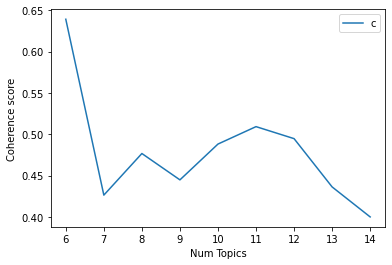

In [30]:
#This will generate multiple topic models with various topic count, then return
# the model with highest coherence it will also display a quick visual of
# coherence values, to understand what topic count is best and why it was chosen
lda_model, corpus = create_lda_model(topic_model_dict["topic_limit"],
                                     topic_model_dict["topic_start"], 
                                     topic_model_dict["topic_step"])

# lda_model is the lda model we will work with, corpus is the actual corpus of articles we use


# Here we are making our dictionary of all articles and their associated
# topic-level sentiment for every topic
topic_level_sentiment = topic_sentence_sentiment_analysis(df, lda_model)


# DATA VISUALIZATION

## Pre-processing dataframe for visualization

Here we preprocess our dataframe to add in a few relevant columns for data vis, as well as creating our topic relevancy dataframe and weighted sentiment dataframe over all topics for all articles. 

We add the Topics, Main Topic, Main Topic Score, and Shortened Address to the main dataframe (using our preprocess_dataframe_for_datavis() function). This lets the data vis section easily grab the information.

Next we create the topic relevancy dataframe df_topics. In df_topics, each row is an article, and each column is a topic. For an article, every cell value represents the relevancy of that topic to that article. So if row 0 column 1 is 0.998, that means Article 0 has a 0.998 relevancy score on Topic 1.

We create the per_topic_df, which uses our topic-based sentiment dictionary and our topic relevancy dataframe to make a dataframe where each row is an article and each column is a topic. The cell contains data of the form (sentiment, relevancy) which is a tuple that describes the sentiment value and topic relevancy of that article (row) for that topic (column).

In [31]:
# This generates our dataframe of per-topic sentiment and relevancy for all articles
df_topics = generate_topic_relevancy_dataframe(lda_model)

# Generate our per-topic dataframe
# FORMAT IS (SENTIMENT, RELEVANCY)
per_topic_df = create_per_topic_tuple_df(topic_level_sentiment, df_topics)

# This generates a dataframe ready to use with our data visualizations
# (includes some extra information)
# This sorts our dataframe so must go last
df = preprocess_dataframe_for_datavis(df, lda_model, corpus)
df


,URL,Sentiment Score,Sentiment Label,Subjectivity Score,Positive Words,Negative Words,Text,Topics,Main Topic,Main Topic Score,Associated Words,Shortened Address
23,https://www.washingtonexaminer.com/news/white-...,-0.06,Neutral,0.48,"more, newly, beautiful, first, not, high, new,...","very, afraid, hard, falsely, deadly, dangerous...",exclusive — hunter biden berated his sister-in...,"[(0, 0.9987387)]",0,0.998739,"[[hunter, hallie, gun, service, secret, tell, ...",www.washingtonexaminer.com
4,https://www.nation.com.pk/21-Jun-2023/hunter-b...,-0.04,Neutral,0.44,"first, detailed, love, not, social, important","foreign, failure, criminal, alleged, other, le...","washigton-hunter biden, the son of president j...","[(0, 0.7291358), (4, 0.2668376)]",0,0.729136,"[[hunter, hallie, gun, service, secret, tell, ...",www.nation.com.pk
41,https://www.washingtonpost.com/politics/2023/1...,0.05,Neutral,0.37,"more, live, especially, exactly, significant, ...","killed, disappointment, least, anger, actually...",listen 9 min share comment on this story comme...,"[(1, 0.75924563), (5, 0.23979272)]",1,0.759246,"[[biden, primary, phillip, state, democratic, ...",www.washingtonpost.com
35,https://www.startribune.com/minnesota-rep-dean...,0.14,Neutral,0.42,"more, prominently, confirmed, elaborate, new, ...","secret, disappointed, behind, cold","concord, n.h. — dean phillips is running for p...","[(1, 0.9956811)]",1,0.995681,"[[biden, primary, phillip, state, democratic, ...",www.startribune.com
34,https://www.wmur.com/article/biden-new-hampshi...,0.22,Neutral,0.47,"more, very, first, best, certainly, uncommon, ...","small, expected, tired, not, least, other, sec",says no matter what happens - new hampshire wi...,"[(1, 0.9966388)]",1,0.996639,"[[biden, primary, phillip, state, democratic, ...",www.wmur.com
33,https://www.washingtonpost.com/politics/2023/1...,0.13,Neutral,0.38,"first, aired, most, wild, accomplished, new, e...","unlikely, least, highly, previous, expected, s...",listen 9 min share comment on this story comme...,"[(1, 0.99886423)]",1,0.998864,"[[biden, primary, phillip, state, democratic, ...",www.washingtonpost.com
32,https://abcnews.go.com/Politics/white-democrat...,0.09,Neutral,0.46,"candidly, more, very, first, large, sure, conf...","down, black, hard, base, expected, other, leas...",minnesota rep. dean phillips' expected decisio...,"[(1, 0.9975301)]",1,0.997530,"[[biden, primary, phillip, state, democratic, ...",abcnews.go.com
31,https://www.foxnews.com/media/james-carville-c...,-0.00,Neutral,0.39,"more, clear, far, controversial, pretty, new, ...","serious, black, illegally, unlikely, historica...",democratic strategist james carville said in a...,"[(1, 0.99587446)]",1,0.995874,"[[biden, primary, phillip, state, democratic, ...",www.foxnews.com
30,https://www.nbcnews.com/politics/2024-election...,0.04,Neutral,0.41,"more, exactly, first, surprised, not, effectiv...","very, little, blatantly, harder, late, base, m...",president joe biden announced in april that he...,"[(1, 0.99817264)]",1,0.998173,"[[biden, primary, phillip, state, democratic, ...",www.nbcnews.com
29,https://www.politico.com/news/2023/10/24/biden...,0.21,Neutral,0.51,"more, general, new, primary, early",,president joe biden’s name will not appear on ...,"[(1, 0.98631257)]",1,0.986313,"[[biden, primary, phillip, state, democratic, ...",www.politico.com


## Data Visualization Settings

Here are the customizable settings for our data visualization section. Since these settings only affect how the data will be visualized, you can rerun the pipeline from this point down without rerunning any of the previous steps. This is recommended if you want to see different parameters for the settings visualized on the same data and LDA model.

In [32]:
# DATA VISUALIZATION SETTINGS
# (starts at topic 0) set this list to every topic number you want
# displayed individually
list_of_topics_to_visualize = [0,1,2]

# this is the settings dictionary for our k-means cluster generation.
# max_clusters is used in our inertia visualization,
# while num_clusters is our actual cluster count to use and pca_components
# is the PCA component count that we use in both
# the visualization of inertia as well as our actual clustering model.
kmeans_settings = {"max_clusters": 10, "num_clusters": 4, "pca_components": 5}



## Visualize all articles on their main topic

In [33]:
%run DataVisualization.ipynb
visualize_all_articles_on_main_topic(df)
visualize_all_articles_on_main_topic(df, plot_type="box")

# Generating Cluster Graph of Topics

In [34]:
visualize_topic_cluster_tsne(lda_model, df)

[t-SNE] Computing 39 nearest neighbors...
[t-SNE] Indexed 40 samples in 0.000s...
[t-SNE] Computed neighbors for 40 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 40 / 40
[t-SNE] Mean sigma: 0.577345
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.121475
[t-SNE] KL divergence after 800 iterations: 0.067366


## Subjectivity vs Sentiment of Articles for a single topic

Will iterate through our list_of_topics_to_visualize and will make a graph for each topic number in that list.

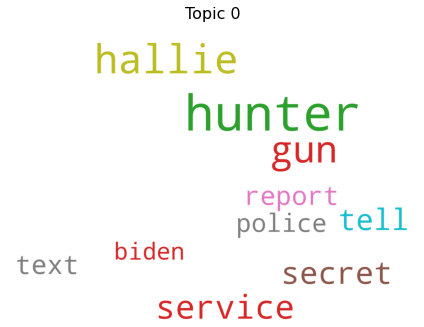

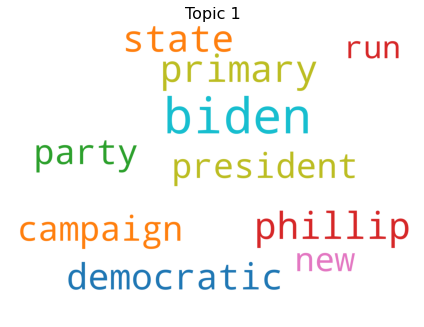

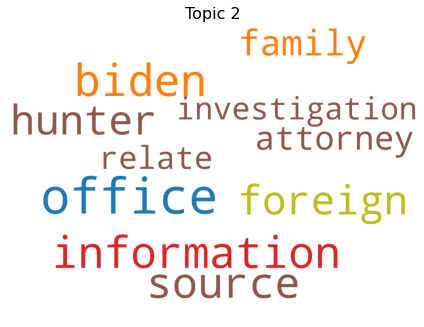

In [35]:
# Using our list_of_topics_to_visualize list in the customizable settings, 
# produce a graph for each topic
for topic_id in list_of_topics_to_visualize:
    if topic_id <= len(lda_model.print_topics()):
        visualize_single_topic_subjectivity_vs_sentiment(df, topic_id)
        visualize_topic_word_cloud(lda_model, topic_id)
    else:
        print("Error, topic_id not availible")


## K means Clustering

Generate a visual of number of topic clusters vs inertia of the model (low inertia is good)

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sk

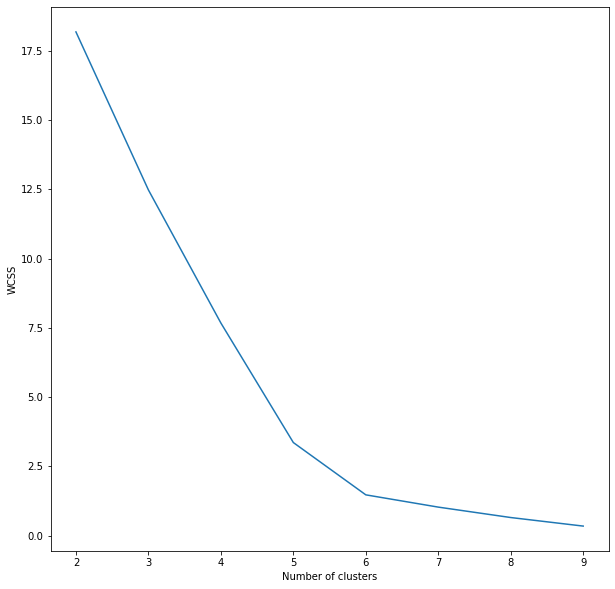

In [36]:
visualize_optimal_cluster_count(df_topics= df_topics,
                                max_clusters= kmeans_settings["max_clusters"],
                                pca_components= kmeans_settings["pca_components"])


Generate actual kmeans clustering

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



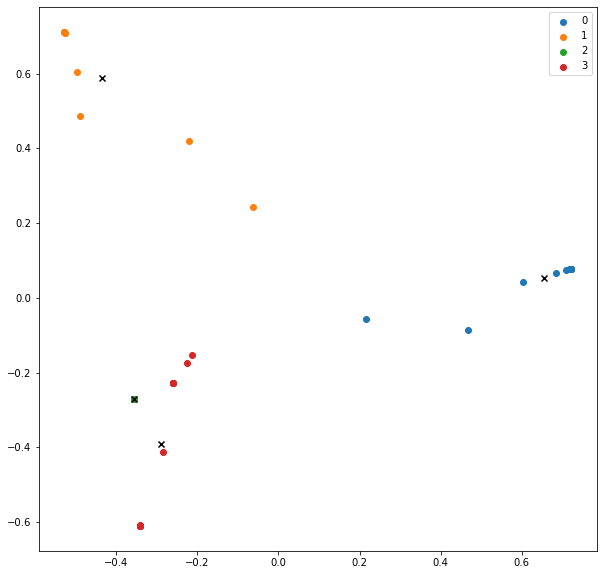

In [37]:
visualize_kmeans_clustering(df_topics= df_topics,
                            num_clusters = kmeans_settings["num_clusters"],
                            pca_components = kmeans_settings["pca_components"])


## Relavence X Sentiment of Articles K-MEANS

           0             1         2         3         4             5
0   0.000009  1.473667e-05  0.000014  0.023378  0.000013  1.322980e-05
1   0.000029  2.491705e-05  0.000025  0.000027  0.070811  2.642266e-05
2  -0.000037 -3.160625e-05 -0.000034 -0.068542 -0.000032 -3.133956e-05
3  -0.000009 -9.425446e-03 -0.000502 -0.000007 -0.008901 -5.710511e-06
4  -0.135302 -1.790041e-04 -0.000163 -0.000157 -0.040751 -1.503211e-04
5   0.000108  1.135614e-04  0.000119  0.106333  0.000120  1.204121e-04
6  -0.000132 -1.247501e-04 -0.000121 -0.093510 -0.000117 -1.170409e-04
7  -0.000003 -3.747793e-08 -0.000002 -0.000002 -0.002660 -2.868755e-07
8  -0.000010 -7.660403e-06 -0.000007 -0.000005 -0.006050 -5.360358e-06
9   0.000004  1.939910e-05  0.000017  0.015142  0.000016  1.708728e-05
10 -0.000007  5.214242e-06  0.005797  0.000004  0.000990  5.814609e-06
11 -0.000008 -7.546628e-06 -0.039898 -0.000009 -0.000009 -8.686457e-06
12 -0.000066 -5.541214e-05 -0.039020 -0.000030 -0.000022 -2.143971e-05
13  0.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



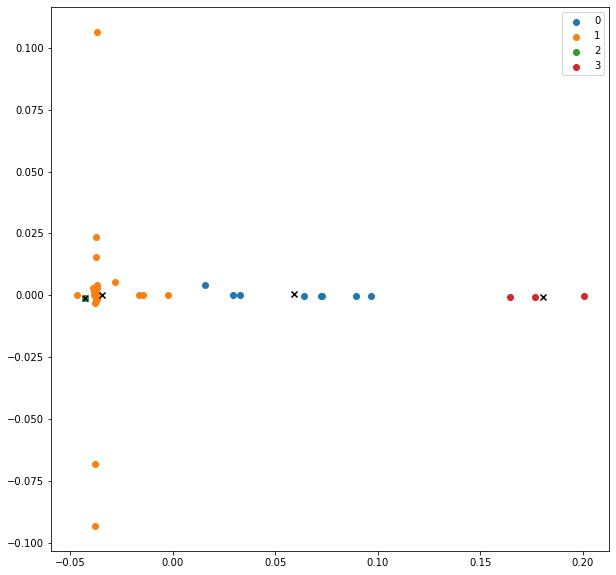

In [38]:
result = multiply_tuples_in_dataframe(per_topic_df)
print(result)

visualize_kmeans_clustering(df_topics= result,
                            num_clusters = kmeans_settings["num_clusters"],
                            pca_components = kmeans_settings["pca_components"])


# Sentiment VS Relavance Per Topic

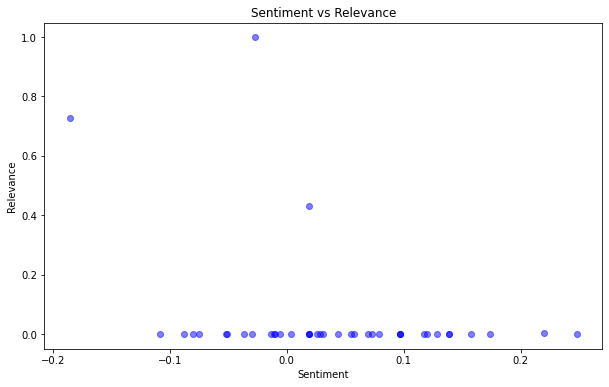

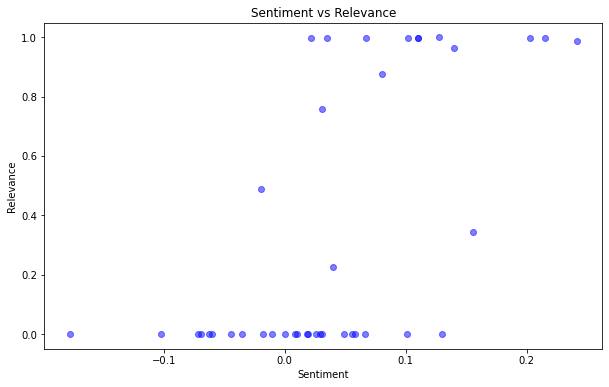

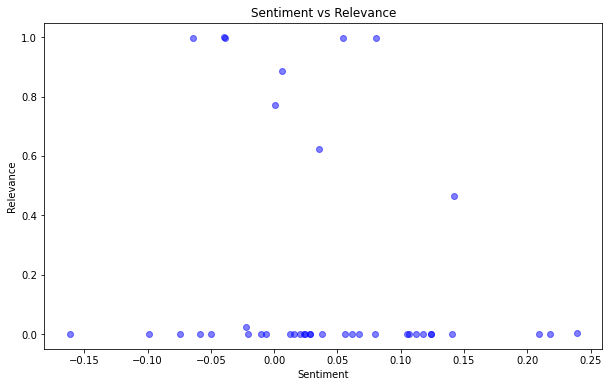

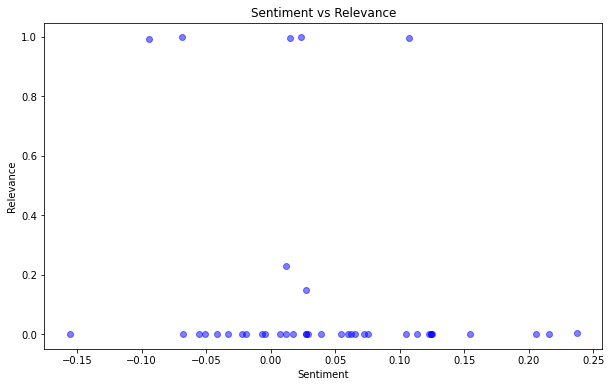

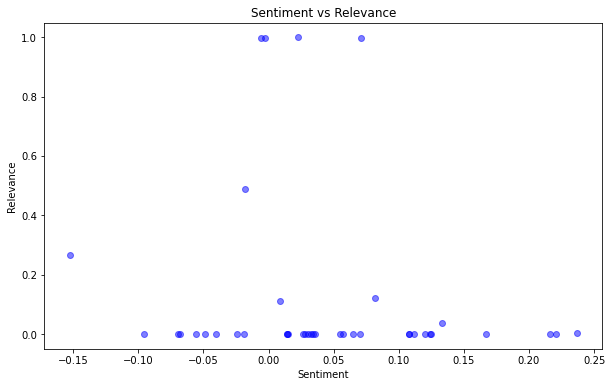

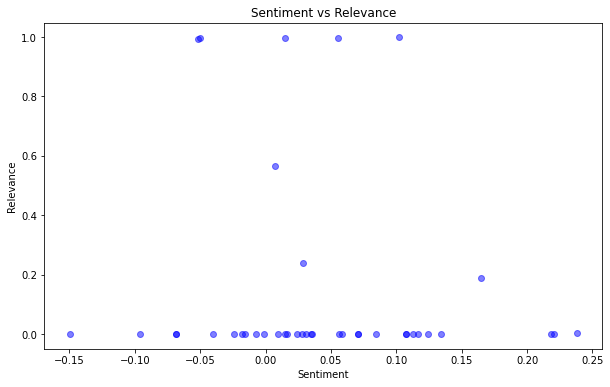

In [39]:
for i in range(len(lda_model.print_topics())):
    plot_sentiment_relevance(per_topic_df[:][i])

# Topic Space

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\seaha\anaconda3\envs\434hw\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



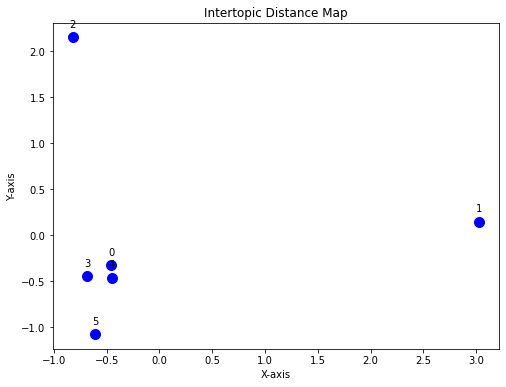

In [40]:
topic_space = dimension_reduction(df_topics)
plot_pca(topic_space)

# Document Sentiment in Topic Space

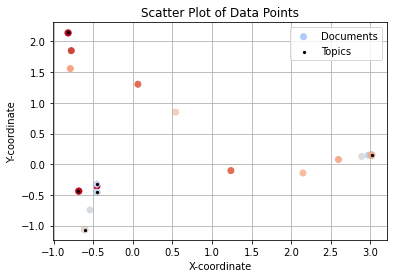

In [41]:
plot_documents(df_topics, topic_space, df)

# Document Density in Topic Space

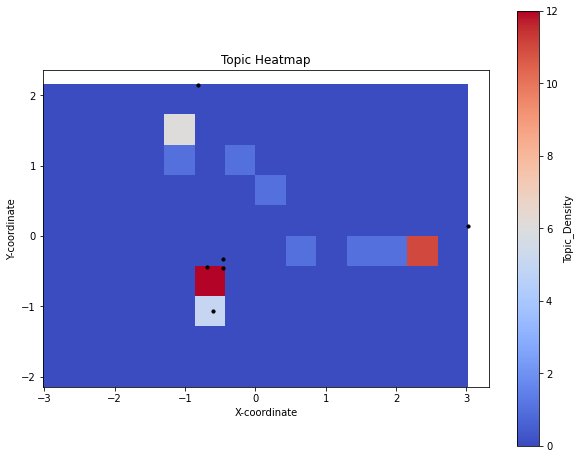

In [42]:
plot_topic_heatmap(df_topics, topic_space)

# Topic per Document in Topic Space

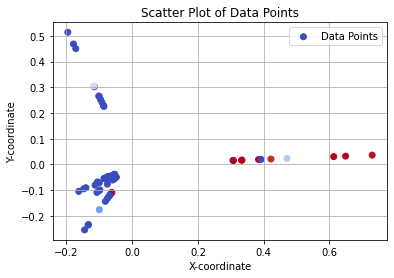

In [43]:
plot_topic_documents(per_topic_df, topic_space)

# Sentiment Sum Heatmap in Topic Space

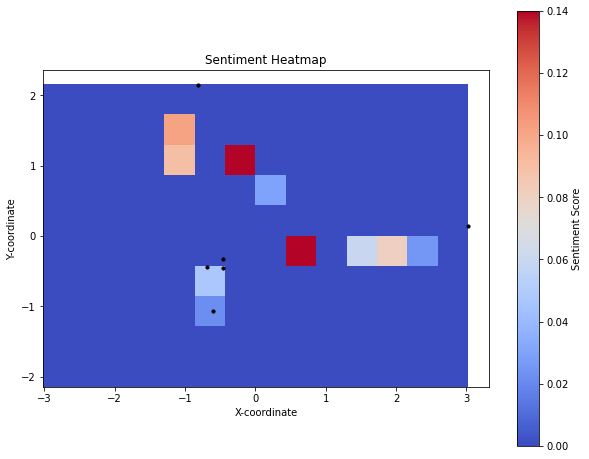

In [44]:
plot_sentiment_heatmap(df_topics, topic_space, df)
